## Problem 1
- In this problem, we have bearing data with 3 classes (healthy, inner fault, outer fault).
- The objective is to classify the given data using state-of-the-art deep learning models.
- You will build and test a deep learning model.

### Dataset Description
The bearing data is collected by a sensory system which has 2 channels: vibration and rotational speed. You can refer to the paper to see the specification in detail. The experimental setup is shown in the below figure. The dataset contains 36 files with 3 classes, 2 sensor positions, and 4 speed varying conditions. Every data is sampled at 200,000 Hz of sampling frequency and 10 seconds of duration. We will use only the <strong>increasing speed</strong> condition and the <strong>channel 1</strong> (vibration data) for the sake of simplicity.

<img src='./me_1.png' width="800" height="200">

### Download & Load Data
We already made the data ready for you. You can download the data in .npy format. Six files are prepared for a train set and three files for a test set.

* Healty_train_1.npy
* Healty_train_2.npy
* InnerFault_train_1.npy
* InnerFault_train_2.npy
* OuterFault_train_1.npy
* OuterFault_train_2.npy


* Healty_test.npy
* InnerFault_test.npy
* OuterFault_test.npy

### 1.1 Plot all data with the title of its filename.

In [2]:
import os
import glob
import random
import numpy as np

import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.getcwd()

'/home/sybaee/Deep Learning'

In [4]:
dict_data = {'train': glob.glob('./bearing_dataset/train/*.npy'),
             'test': glob.glob('./bearing_dataset/test/*.npy')}

for files in dict_data.values():
    for file_name in files:
        var_name = file_name.split('/')[-1][:-4]
        vars()[var_name] = np.load(file_name)

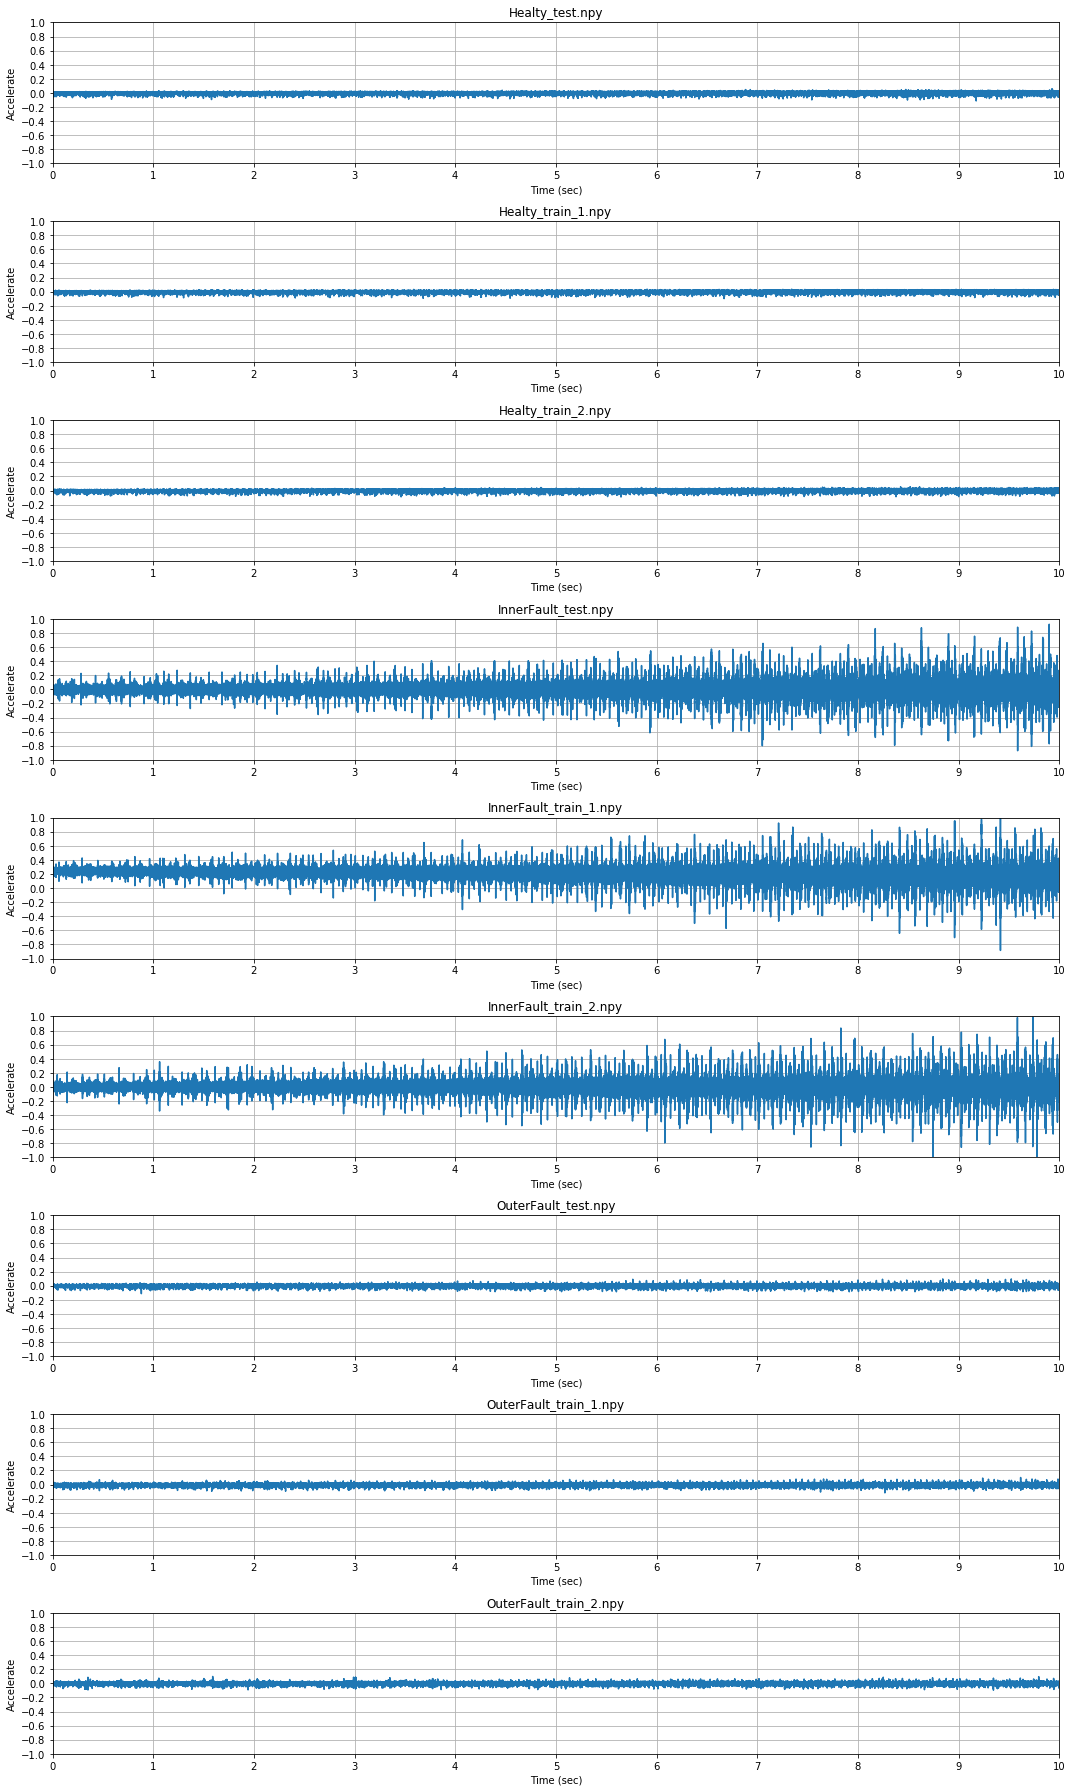

In [5]:
file_names = sorted([file_name.split('/')[-1] for files in dict_data.values() 
                     for file_name in files])

t = np.arange(0, 10, 10 / Healty_train_1.shape[0])
fig, axes = plt.subplots(len(file_names), figsize=(15, 25))
for index, file_name in enumerate(file_names):
    axes[index].grid()
    axes[index].set_xlim(0, 10)
    axes[index].set_ylim(-1, 1)
    axes[index].set_xticks(np.arange(0, 11, 1))
    axes[index].set_yticks(np.arange(-1, 1.2, 0.2))
    axes[index].plot(t, vars()[file_name[:-4]])
    axes[index].set_xlabel('Time (sec)')
    axes[index].set_ylabel('Accelerate')
    axes[index].set_title('{}'.format(file_name), fontsize=12)
    
fig.tight_layout()
plt.show()

In the following subproblems, you will be introduced deep learning models which are used for time-series data classification. You are asked to build the model with the given architecture and evaluate the performance.

### Various deep learning models for time-series data classification
In the deep learning field, there are plenty of models for time-series data classification. Compared to conventional machine learning algorithms, recent deep neural network models show much higher accuracy as you can see in the table below. In this problem, we will build the <strong>CNN-LSTM model</strong> which is one of the most successful, and whose elements are covered in this course.

### Implementation of CNN-LSTM model
The CNN-LSTM model is introduced in "An Improved Bearing Fault Diagnosis Method using One-Dimensional CNN and LSTM". The authors combined 1D CNN and LSTM succesfully and it shows high performance in terms of both computation time and accuracy. The following configuration shows a part of the structure of the model. The model takes the segmented data as an input. A data segment which has a length of 1,600 is randomly cropped from the original time-series data.

<img src='./me_2.png' width="800" height="200">

### 1.2 Build the model based on the above information and print the structure.
Build the model based on the above information and print the structure. You can freely assign the other parameters that are not described in the above configuration in order to achieve better performance. (You don't need to refer the original paper for those.) Please refer to the summary of the model structure.

You will use the 1D convolution layer for this problem. We have learned 2D convolution in class and 1D convolution is nothing but 2D convolution with a height as 1.

<strong>Input_shape of data = (1600,)</strong>

In [21]:
n_input = 20
n_step = 80
n_output = 3

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1600, )),
    tf.keras.layers.Reshape((n_step, n_input), input_shape=(None, 1600)),
    tf.keras.layers.Conv1D(filters=32, 
                           kernel_size=(64),
                           padding='SAME',
                           activation='relu',
                           input_shape=(None, n_step, n_input)), 
    tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, activation='softmax'),
    tf.keras.layers.Dense(n_output)])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 80, 20)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 32)            40992     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 123,811
Trainable params: 123,811
Non-trainable params: 0
__________________________________________________

### 1.3 Create trainset and testset
Create trainset and testset to feed the model you designed. Set the number of segments equals to 4,000 for trainset and 1,000 for testset (for each class).

In [10]:
def dataset(data, n_samples, label):
    train_x_list = []
    sample_limit = len(data) - (n_step*n_input)
    for i in random.sample(range(sample_limit), n_samples):
        train_x = data[i: i+(n_step*n_input)]
        train_x_list.append(train_x)
    
    train_y = np.tile([label], n_samples)
        
    train_data = np.array(train_x_list)
    train_label = np.array(train_y)
    
    return train_data, train_label

In [11]:
train_segment = 2000
test_segment = 1000
ohe = OneHotEncoder(handle_unknown='ignore')

In [12]:
train_x, train_y = [], []
for index, var_name in enumerate(sorted([file_name.split('/')[-1][:-4] 
                                         for file_name in dict_data['train']])):
    label = index // 2
    data_x, data_y = dataset(vars()[var_name], train_segment, label)
    
    train_x.append(data_x)
    train_y.append(data_y)
    
train_x_stacked = np.vstack(train_x)
train_y_stacked = ohe.fit_transform(np.hstack(train_y).reshape(-1, 1)).toarray()

In [13]:
test_x, test_y = [], []
for index, var_name in enumerate(sorted([file_name.split('/')[-1][:-4] 
                                         for file_name in dict_data['test']])):
    label = index
    data_x, data_y = dataset(vars()[var_name], test_segment, label)
    
    test_x.append(data_x)
    test_y.append(data_y)
    
test_x_stacked = np.vstack(test_x)
test_y_stacked = ohe.fit_transform(np.hstack(test_y).reshape(-1, 1)).toarray()

In [14]:
train_x_stacked.shape, train_y_stacked.shape, test_x_stacked.shape, test_y_stacked.shape

((12000, 1600), (12000, 3), (3000, 1600), (3000, 3))

### 1.4 Plot a random segment for both trainset and testset.
Hint: Reshape the segment into (1600, ) if necessary.

In [15]:
n_step, n_input, n_step*n_input

(80, 20, 1600)

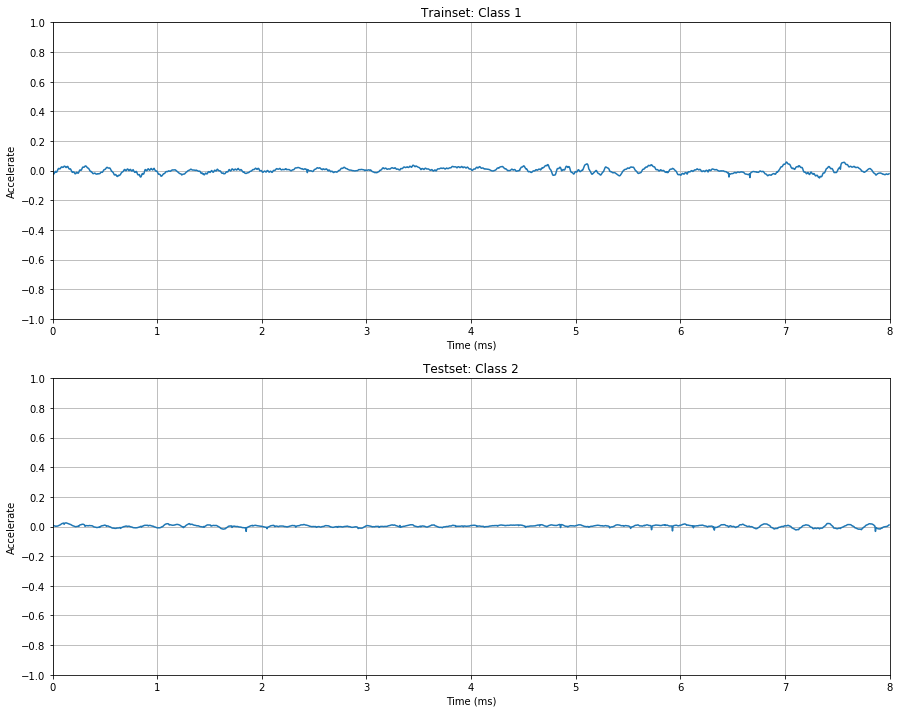

In [16]:
t = np.arange(0, 8, 8 / (n_step*n_input))

fig, axes = plt.subplots(2, figsize=(15, 12))
for i in range(2):
    plot_data_x = train_x_stacked if i == 0 else test_x_stacked
    plot_data_y = train_y_stacked if i == 0 else test_y_stacked
    title = 'Trainset' if i == 0 else 'Testset'
    rand_num = np.random.randint(len(plot_data_x))
    
    axes[i].grid()
    axes[i].set_xlim(0, 8)
    axes[i].set_ylim(-1, 1)
    axes[i].set_xticks(np.arange(0, 9, 1))
    axes[i].set_yticks(np.arange(-1, 1.2, 0.2))
    axes[i].plot(t, plot_data_x[rand_num])
    axes[i].set_xlabel('Time (ms)')
    axes[i].set_ylabel('Accelerate')
    axes[i].set_title('{}: Class {}'.format(title, 
                                            np.argmax(plot_data_y[rand_num])))

plt.show()

### 1.5 Train the model and print the training procedure.

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='mse',
              metrics=['accuracy'])

In [23]:
model.fit(train_x_stacked, train_y_stacked, batch_size=100, epochs=20)
# print out the model accuracy, but you do not have to print it out like below

Epoch 1/20
120/120 [==============================] - 4s 24ms/step - loss: 0.2357 - accuracy: 0.4835
Epoch 2/20
120/120 [==============================] - 3s 23ms/step - loss: 0.1148 - accuracy: 0.6783
Epoch 3/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0514 - accuracy: 0.8984
Epoch 4/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0203 - accuracy: 0.9626
Epoch 5/20
120/120 [==============================] - 3s 24ms/step - loss: 0.0160 - accuracy: 0.9670
Epoch 6/20
120/120 [==============================] - 3s 24ms/step - loss: 0.0133 - accuracy: 0.9751
Epoch 7/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0097 - accuracy: 0.9810
Epoch 8/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0071 - accuracy: 0.9868
Epoch 9/20
120/120 [==============================] - 3s 24ms/step - loss: 0.0058 - accuracy: 0.9894
Epoch 10/20
120/120 [==============================] - 3s 24ms/step - loss: 0.0045 - accura

### 1.6 Evaluate the model in terms of accuracy of the testset.


In [24]:
model.evaluate(test_x_stacked, test_y_stacked)
# print out the model accuracy, but you do not have to print it out like below

94/94 [==============================] - 4s 25ms/step - loss: 0.0073 - accuracy: 0.9853


[0.0072703598998487, 0.9853333234786987]

## Problem 2
- In this problem, we are going to predict sequence data using LSTM model
- You will build and test a deep learning model.

The data, which includes variables such as combustor power, compressor power, compressor pressure, blade tip temperature, blade tip acceleration, blade tip velocity, and relative pressure, is given at every minute. We will create a deep learning model that makes use of sequential properties. The compressor power for time  𝑡  will be predicted using the data provided at time  𝑡−1 . In other words, 7 input variables at time  𝑡−1  is used to predict combustor power at time  𝑡 .

### Download & Load Data

We've already prepared the data. You can download the data in .txt format.

In [25]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_csv('./data.txt', sep=';', 
                 parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

# filling nan with mean in any columns
for j in range(0, 7):        
    df.iloc[:, j] = df.iloc[:, j].fillna(df.iloc[:, j].mean())
    
df

,Combustor power,Compressor power,Blade tip temperature,Compressor pressure,Blade tip acceleration,Relative pressure,Blade tip velocity
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [27]:
df_resample = df.resample('h').mean() 
df_resample

,Combustor power,Compressor power,Blade tip temperature,Compressor pressure,Blade tip acceleration,Relative pressure,Blade tip velocity
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


In [28]:
dataset = df_resample.values
print(dataset.shape)

(34589, 7)


### 2.1 Data visualization
Plot all data with the title of its variable name.

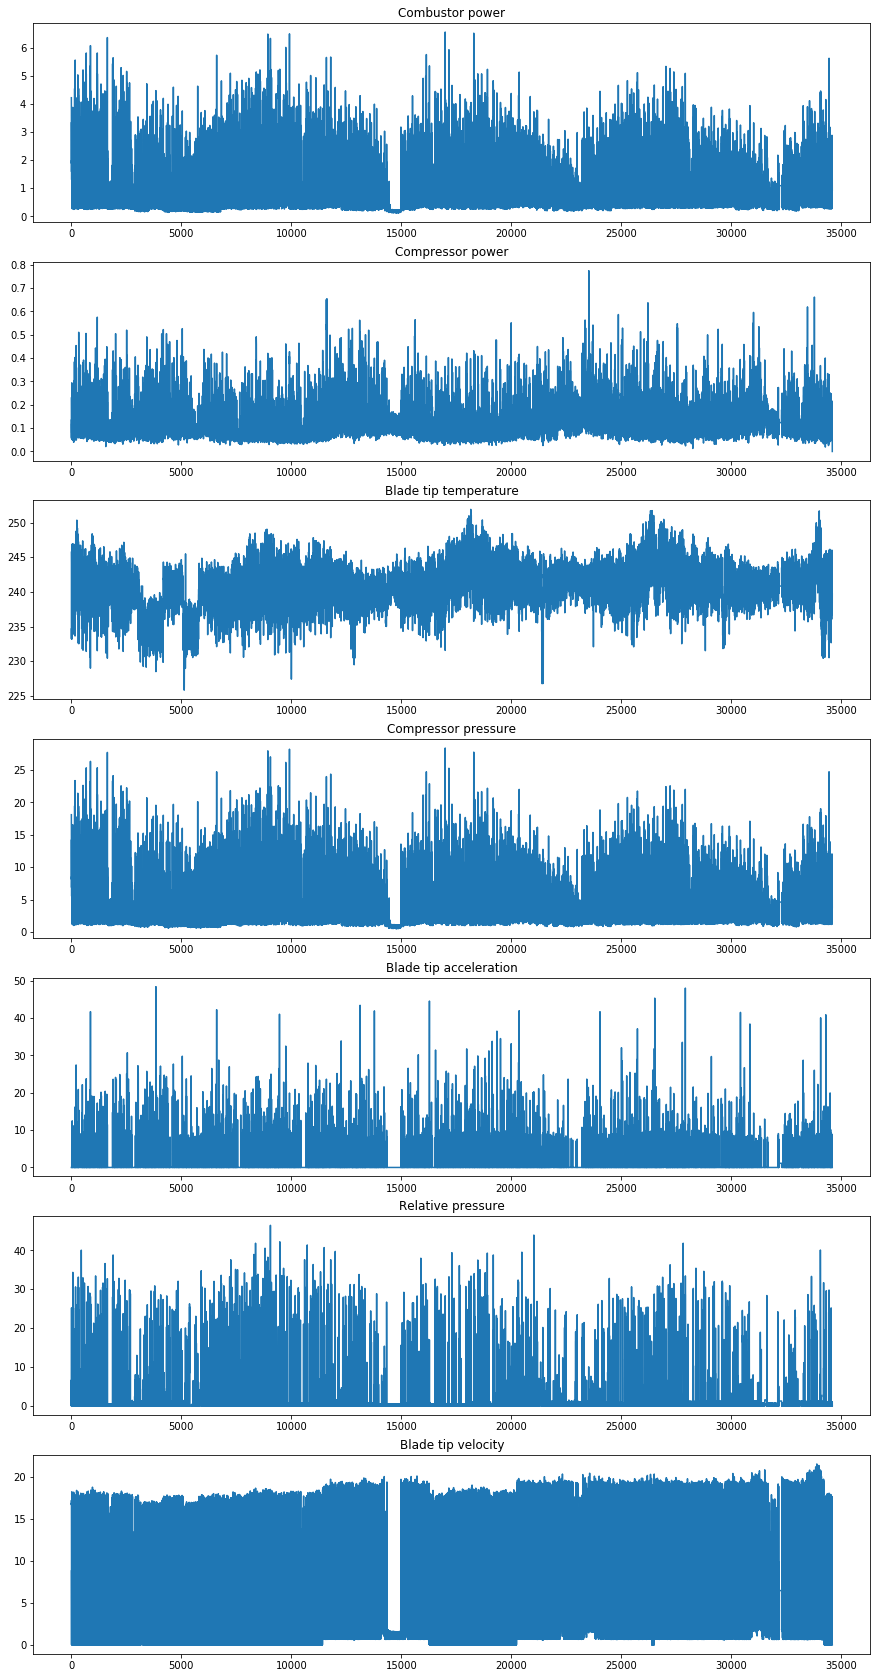

In [29]:
t = np.arange(0, len(dataset))
fig, axes = plt.subplots(dataset.shape[-1], figsize=(15, 30))
for index, label in enumerate(range(dataset.shape[-1])):
    axes[index].plot(t, dataset.T[label])
    axes[index].set_title('{}'.format(df.columns[index]))
    
plt.show()

### 2.2 Preprocessing
Each variables has different scale. Normalize the dataset.

In [30]:
scaler = MinMaxScaler()
scaler.fit(dataset)
norm_dataset = scaler.transform(dataset)

In [31]:
norm_dataset.shape

(34589, 7)

In [32]:
print('min value:{:.1f}, max value:{:.1f}'.format(np.min(norm_dataset), np.max(norm_dataset)))

min value:0.0, max value:1.0


### 2.3 Split dataset
(2.3.1) Referring to below image, create train and target data.

<img src='./me_3.png' width="800" height="200">

In [33]:
df_scaled = pd.DataFrame(norm_dataset, columns=[col + ' (t-1)' 
                                                for col in df.columns])
df_train_target = df_scaled.iloc[:-1, :]
df_train_target['Combustor power (t)'] = df_scaled.iloc[1:, 0].values

/tmp/ipykernel_366921/1620000930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_target['Combustor power (t)'] = df_scaled.iloc[1:, 0].values


In [34]:
df_train_target

,Combustor power (t-1),Compressor power (t-1),Blade tip temperature (t-1),Compressor pressure (t-1),Blade tip acceleration (t-1),Relative pressure (t-1),Blade tip velocity (t-1),Combustor power (t)
0,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
1,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
2,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
3,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
4,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555
...,...,...,...,...,...,...,...,...
34583,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000,0.248876
34584,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.225194
34585,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.238534
34586,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.161531


(2.3.2) Set the trainset to 3 years and the testset to the remaining datasets.

Hint: Since the data set is recorded hour by hour, 365*24 data are one-year data

In [35]:
year = 3
df_train = df_train_target.iloc[:365*24*year, :].to_numpy()
df_test = df_train_target.iloc[365*24*year:, :].to_numpy()

train_x = df_train[:, :7]
train_y = df_train[:, -1]
test_x = df_test[:, :7]
test_y = df_test[:, -1]

In [36]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((26280, 7), (26280,), (8308, 7), (8308,))

### 2.4 Create model
Create a model by referring to below result. Use mean squared error as loss function.

In [37]:
n_step = 1
n_input = 7

# LSTM shape
n_lstm1 = 100
n_lstm2 = 100

# fully connected
n_output = 1

lstm_network = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_step, n_input)),
    tf.keras.layers.LSTM(n_lstm1, return_sequences=True),
    tf.keras.layers.LSTM(n_lstm2),
    tf.keras.layers.Dense(n_output)])

In [38]:
lstm_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            43200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________


In [39]:
lstm_network.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

### 2.5 Train the model

In [40]:
train_x.shape, train_x.reshape(-1, 1, 7).shape

((26280, 7), (26280, 1, 7))

In [41]:
lstm_network.fit(train_x.reshape(-1, 1, 7), train_y, epochs=30)

Epoch 1/30
822/822 [==============================] - 7s 6ms/step - loss: 0.0126
Epoch 2/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0095
Epoch 3/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0095
Epoch 4/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0092
Epoch 5/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0094
Epoch 6/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0095
Epoch 7/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0092
Epoch 8/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0093
Epoch 9/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0091
Epoch 10/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0090
Epoch 11/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0093
Epoch 12/30
822/822 [==============================] - 5s 6ms/step - loss: 0.0092
Epoch 13/30
822/822 [====

### 2.6 Plot the result
Predict your test dataset and compare the prediction value with target value.

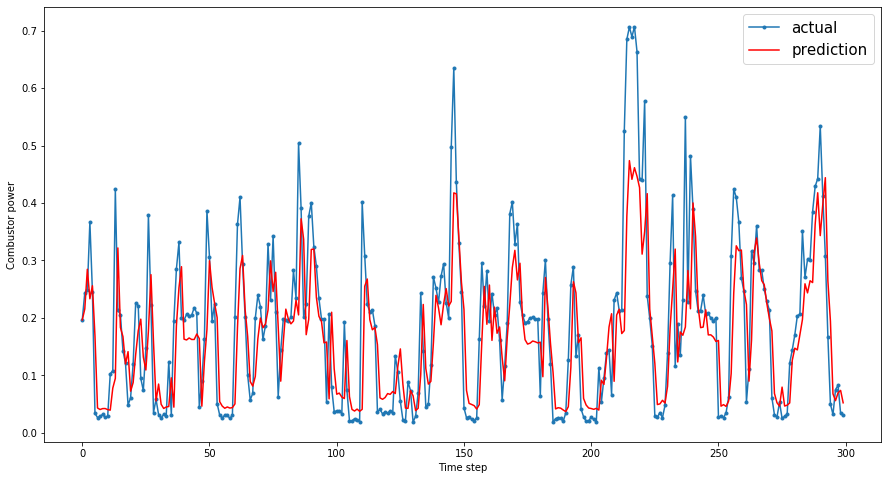

In [42]:
time_step = 300
gen_signal = []
for i in range(time_step):
    test_pred = lstm_network.predict(test_x[i].reshape(-1, 1, 7))
    gen_signal.append(test_pred.ravel())

gen_signal = np.concatenate(gen_signal)

test_label = test_y[:time_step]

plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, time_step), test_label, '.-', label='actual')
plt.plot(np.arange(0, time_step), gen_signal, 'r', label='prediction')
plt.xlabel('Time step')
plt.ylabel('Combustor power')
plt.legend(fontsize=15, loc='upper right')

plt.show()